# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


In [1]:
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

--2025-05-15 06:10:41--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.118, 3.171.22.33, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip’

SST-2.zip           100%[===================>]   7.09M  36.6MB/s    in 0.2s    

2025-05-15 06:10:41 (36.6 MB/s) - ‘SST-2.zip’ saved [7439277/7439277]

Archive:  SST-2.zip
   creating: SST-2/
  inflating: SST-2/dev.tsv           
   creating: SST-2/original/
  inflating: SST-2/original/README.txt  
  inflating: SST-2/original/SOStr.txt  
  inflating: SST-2/original/STree.txt  
  inflating: SST-2/original/datasetSentences.txt  
  inflating: SST-2/original/datasetSplit.txt  
  inflating: SST-2/original/dictionary.txt  
  inflating: SST-2/original/original_rt_snippets.txt  
  inflating: SST-2/original/sentime

## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [2]:
import pandas as pd

train=pd.read_csv("/content/SST-2/train.tsv",sep="\t")#tsvはタブ区切り
dev=pd.read_csv("/content/SST-2/dev.tsv",sep="\t")

print(f"学習データ:\n{train['label'].value_counts()}\n")
print(f"検証データ:\n{dev['label'].value_counts()}")

学習データ:
label
1    37569
0    29780
Name: count, dtype: int64

検証データ:
label
1    444
0    428
Name: count, dtype: int64


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [3]:
def make_feature(sentence, label):
  data={"text":sentence, "label":label, "feature":{}}
  for i in sentence.split():
    if i not in data["feature"]:
      data["feature"][i] = 0
    data["feature"][i] += 1
  return data


train_data = []
for sentence, label in zip(train["sentence"], train["label"]):
  train_data.append(make_feature(sentence, label))

dev_data = []
for sentence, label in zip(dev["sentence"], dev["label"]):
  dev_data.append(make_feature(sentence, label))

print(train_data[0])

{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

vec=DictVectorizer()
X_train=vec.fit_transform([data["feature"] for data in train_data])
y_train=[data["label"] for data in train_data]
X_dev=vec.transform([data["feature"] for data in dev_data])
y_dev=[data["label"] for data in dev_data]

model=LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [5]:
dev_1st_sentence = dev_data[0]["text"]
dev_1st_feature = vec.transform([dev_data[0]["feature"]])
dev_1st_label = dev_data[0]["label"]

pred = model.predict(dev_1st_feature)#中身1の配列

print(f"文: {dev_1st_sentence}")
print(f"予測ラベル: {pred[0]}\n正解ラベル: {dev_1st_label}")

文: it 's a charming and often affecting journey . 
予測ラベル: 1
正解ラベル: 1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [6]:
prob = model.predict_proba(dev_1st_feature)

print(f"ポジティブラベルの確率: {prob[0][1]}\nネガティブラベルの確率: {prob[0][0]}")

ポジティブラベルの確率: 0.9957220070981616
ネガティブラベルの確率: 0.00427799290183839


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [7]:
def make_feature1(sentence):
  data = {"feature":{}}
  for i in sentence.split():
    if i not in data["feature"]:
      data["feature"][i] = 0
    data["feature"][i] += 1
  return data


test_sentence = "the worst movie I 've ever seen"
data = make_feature1(test_sentence)
feature = vec.transform([data["feature"]])
pred = model.predict(feature)

print(f"文: {test_sentence}\n予測結果: {pred[0]}")

文: the worst movie I 've ever seen
予測結果: 0


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [8]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_dev)
conf_mat = confusion_matrix(y_dev, pred)

print(conf_mat)

[[334  94]
 [ 73 371]]


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_dev = model.predict(X_dev)

print(f"正解率: {accuracy_score(y_dev, pred_dev)}")
print(f"適合率: {precision_score(y_dev, pred_dev)}")
print(f"再現率: {recall_score(y_dev, pred_dev)}")
print(f"F1スコア: {f1_score(y_dev, pred_dev)}")

正解率: 0.8084862385321101
適合率: 0.7978494623655914
再現率: 0.8355855855855856
F1スコア: 0.8162816281628162


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [10]:
feature_names = vec.get_feature_names_out()
coef = model.coef_[0]
a = list(zip(feature_names, coef))
top20 = sorted(a, key=lambda x: x[1], reverse=True)[:20]
worst20 = sorted(a, key=lambda x: x[1])[:20]

print("重みの高い特徴量トップ20")
for i,(j,k) in enumerate(top20,1):
  print(f"{i}  {j:<13}\t{k:4f}")

print("\n重みの低い特徴量トップ20")
for i,(j,k) in enumerate(worst20,1):
  print(f"{i}  {j:<13}\t{k:4f}")

重みの高い特徴量トップ20
1  refreshing   	3.413905
2  remarkable   	3.401332
3  powerful     	3.209044
4  hilarious    	3.164218
5  beautiful    	2.993045
6  wonderful    	2.961129
7  prose        	2.891201
8  appealing    	2.848768
9  terrific     	2.845935
10  treat        	2.791234
11  enjoyable    	2.780471
12  charmer      	2.748543
13  vividly      	2.707208
14  likable      	2.674239
15  charming     	2.645338
16  solid        	2.644748
17  fascinating  	2.616087
18  half-bad     	2.592260
19  impressive   	2.587231
20  intriguing   	2.576110

重みの低い特徴量トップ20
1  lacking      	-4.323334
2  lacks        	-4.056426
3  worst        	-4.000704
4  devoid       	-3.639067
5  mess         	-3.585644
6  failure      	-3.547112
7  stupid       	-3.327829
8  bore         	-3.238688
9  flat         	-3.221390
10  depressing   	-3.170987
11  loses        	-3.154406
12  waste        	-3.141332
13  lack         	-3.036523
14  none         	-3.021101
15  hardly       	-3.018439
16  squanders    	-3.012719
1

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

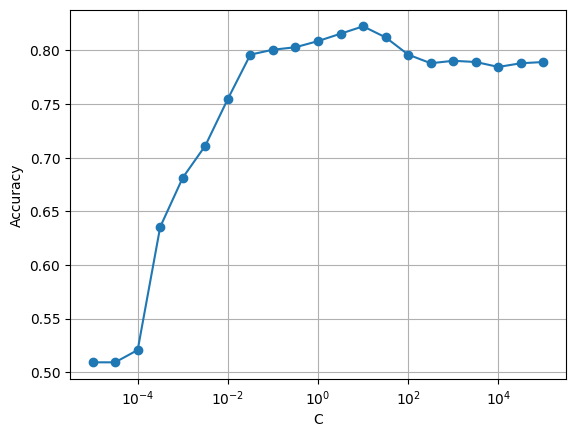

In [14]:
import numpy as np
import matplotlib.pyplot as plt

C_values = np.logspace(-5, 5, 21)
list=[]

for c in C_values:
  model = LogisticRegression(C=c, max_iter=1000)
  model.fit(X_train, y_train)
  pred = model.predict(X_dev)
  list.append(accuracy_score(y_dev, pred))


plt.semilogx(C_values, list, marker="o")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()